In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
parent_parent_dir = os.path.dirname(parent_dir)

if parent_parent_dir not in sys.path:
    sys.path.append(parent_parent_dir)

from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [4]:
sheet = pd.read_excel('data_input/日均铁水产量.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['日均铁水产量'].last_valid_index()
# 获取last_day之后的数据
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet = sheet.sort_index()


fill_methods = {
    '日均铁水产量模拟值(预测/装置跟踪)': 'interpolate',
    '螺纹高炉利润/上海/即期': 'interpolate',
    '热卷高炉利润/上海/即期': 'interpolate',
    '247家钢铁企业盈利率':'interpolate',
    '热卷厂内/社会库存比值':'interpolate',
    '螺纹盘面利润':'interpolate',
    '铁矿钢厂库存Trend/F0.1':'interpolate',
    '铁矿基差率':'interpolate',
    '焦炭基差率':'interpolate',
    '五大钢材周度表需(预测/3年季节性/20期)':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '日均铁水产量'] = sheet.loc[:last_day, '日均铁水产量'].interpolate(method='linear')

sheet['螺纹高炉利润/上海/即期_提前35天'] = sheet['螺纹高炉利润/上海/即期'].shift(35)
sheet['热卷高炉利润/上海/即期_提前35天'] = sheet['热卷高炉利润/上海/即期'].shift(35)
sheet['247家钢铁企业盈利率_提前28天'] = sheet['247家钢铁企业盈利率'].shift(28)
sheet['热卷厂内/社会库存比值_提前42天'] = sheet['热卷厂内/社会库存比值'].shift(42)
sheet['螺纹盘面利润_提前56天'] = sheet['螺纹盘面利润'].shift(56)
sheet['铁矿钢厂库存Trend/F0.1_提前56天'] = sheet['铁矿钢厂库存Trend/F0.1'].shift(56)
sheet['铁矿基差率_提前28天'] = sheet['铁矿基差率'].shift(28)

sheet['热卷厂内/社会库存比值_提前42天_逆序'] = reverse_column(sheet, '热卷厂内/社会库存比值_提前42天')
sheet['铁矿基差率_提前28天_逆序'] = reverse_column(sheet, '铁矿基差率_提前28天')
sheet['铁矿钢厂库存Trend/F0.1_提前56天_逆序'] = reverse_column(sheet, '铁矿钢厂库存Trend/F0.1_提前56天')

sheet['铁矿基差率_提前28天_逆序_2024-01-01之后'] = np.where(
    sheet.index >= pd.Timestamp('2024-01-01'),
    sheet['铁矿基差率_提前28天_逆序'],
    np.nan
)
################################# 数据筛选  #################################
# 重置索引 确保 `Date` 为 datetime 类型
sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
# 筛选日期大于 2024-01-01 的行
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-02-20')]
# 重置索引,使其从0开始 
sheet_daily = sheet_daily.reset_index(drop=True)
# 删除 在 last_day 之前 预测标的 为 空值的 行
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['日均铁水产量'].notna())
]


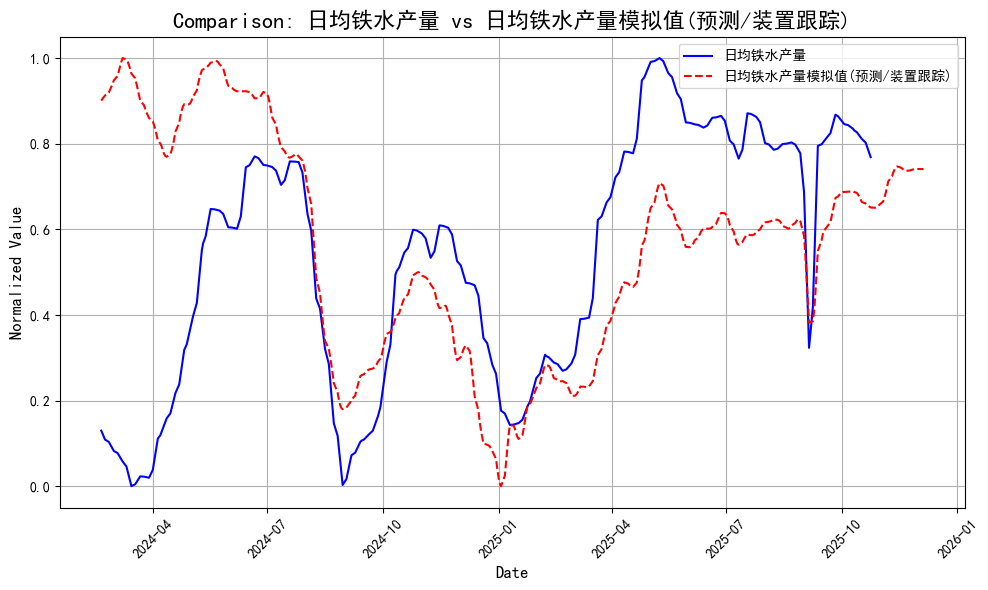

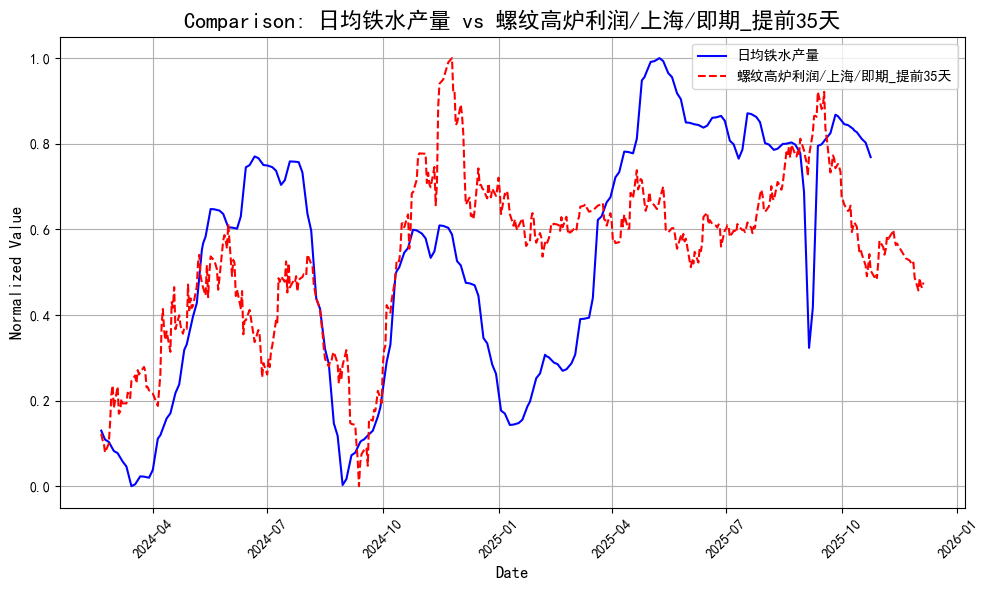

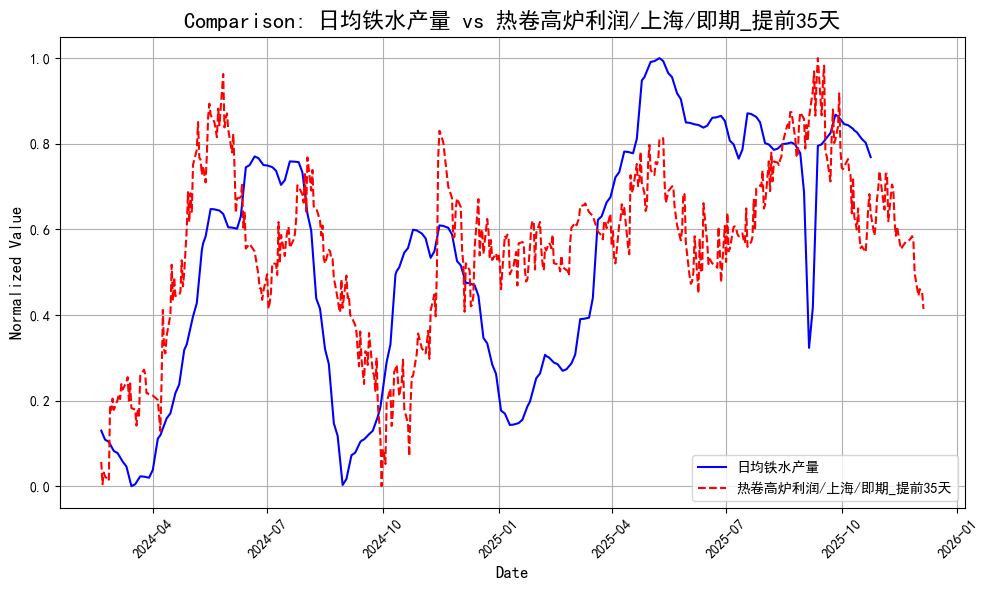

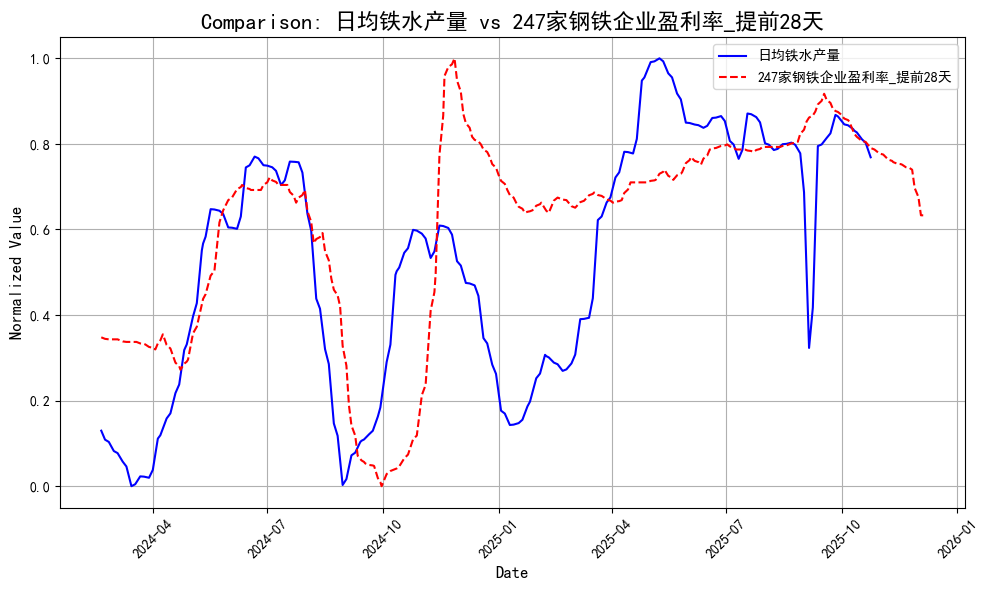

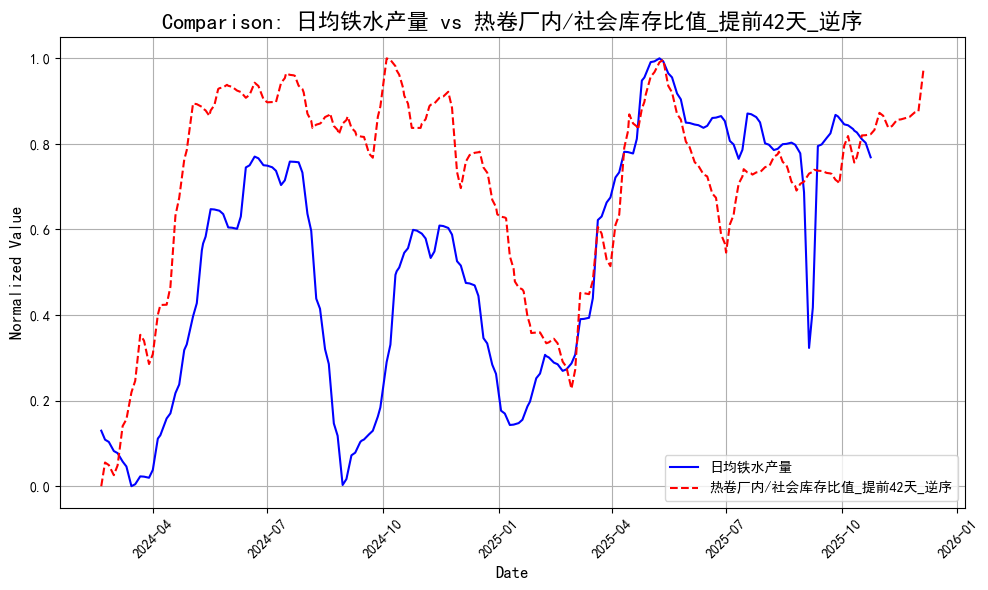

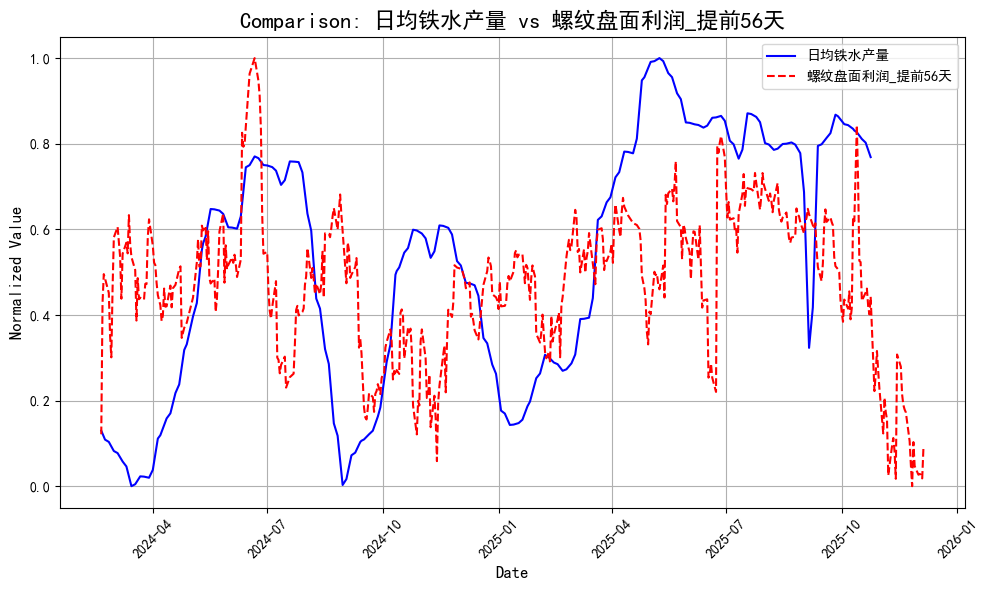

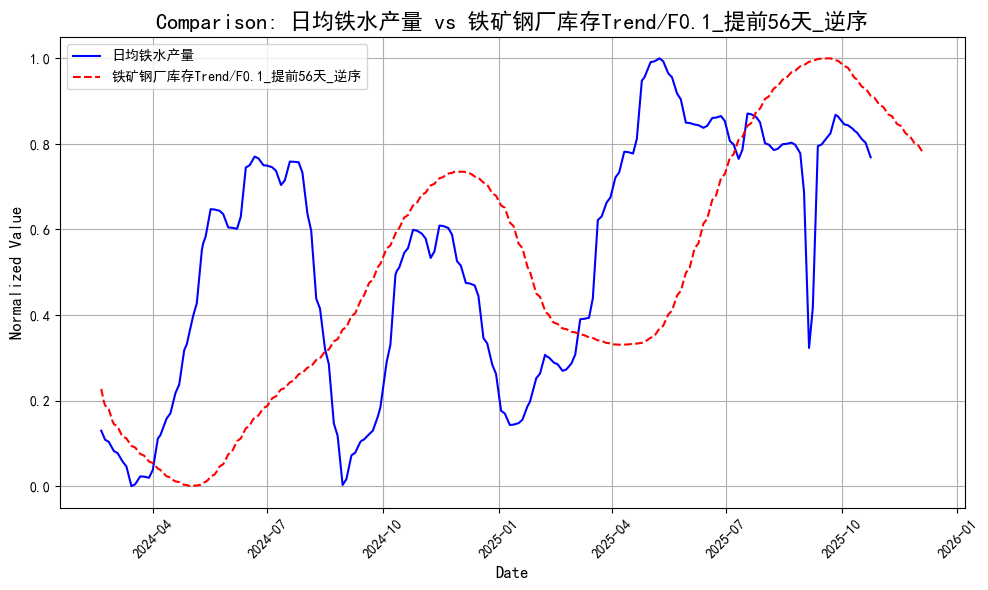

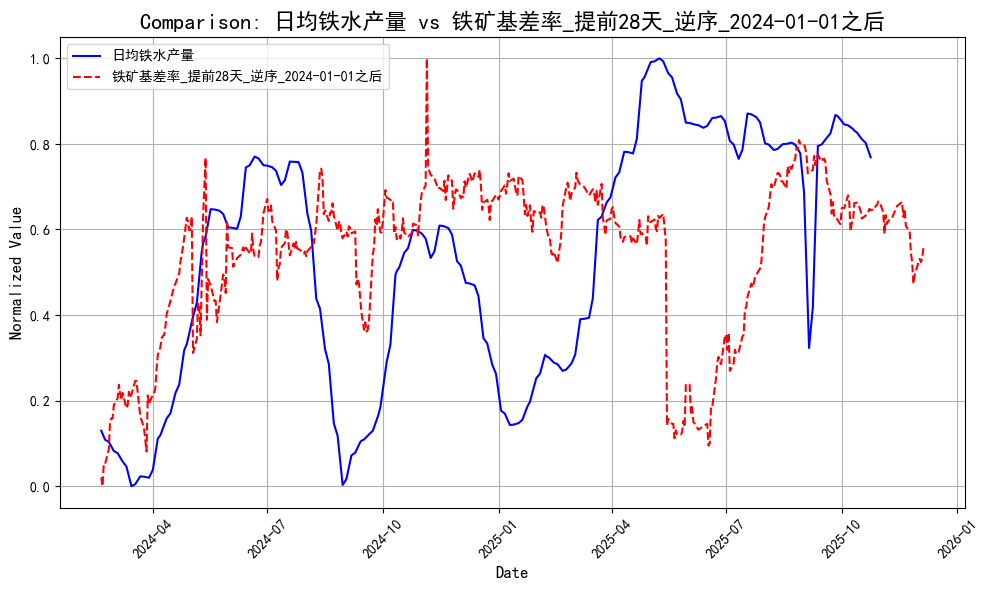

In [5]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='日均铁水产量', 
    compare_cols=[
        '日均铁水产量模拟值(预测/装置跟踪)', '螺纹高炉利润/上海/即期_提前35天', 
        '热卷高炉利润/上海/即期_提前35天','247家钢铁企业盈利率_提前28天', 
        '热卷厂内/社会库存比值_提前42天_逆序', '螺纹盘面利润_提前56天', 
        '铁矿钢厂库存Trend/F0.1_提前56天_逆序', '铁矿基差率_提前28天_逆序_2024-01-01之后'
        ]
)

In [6]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 10
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '日均铁水产量模拟值(预测/装置跟踪)', 
        '螺纹高炉利润/上海/即期_提前35天', 
        '热卷高炉利润/上海/即期_提前35天',
        '247家钢铁企业盈利率_提前28天', 
        '热卷厂内/社会库存比值_提前42天_逆序', 
        '螺纹盘面利润_提前56天', 
        '铁矿钢厂库存Trend/F0.1_提前56天_逆序', 
        #'铁矿基差率_提前28天_逆序_2024-01-01之后'
]

predict_column = '日均铁水产量'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.09,  # 较小的学习率
    'max_depth': 7,  # 控制树的深度防止过拟合
    'min_child_weight': 3,  # 控制过拟合
    'subsample': 0.8,  # 随机采样防止过拟合
    'colsample_bytree': 0.9,  # 特征随机采样
    'gamma': 0.05,  # 控制分裂
    'reg_alpha': 0.1,  # L1正则化
    'reg_lambda': 1.0,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}

num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:6.21501	train-rmse:6.54328


[500]	eval-rmse:1.01333	train-rmse:0.11943


[1000]	eval-rmse:1.01222	train-rmse:0.11747


[1368]	eval-rmse:1.01060	train-rmse:0.11644


训练集 MSE (DMatrix): 0.0136, 训练集 R² (DMatrix): 0.9997
测试集 MSE (DMatrix): 1.0212, 测试集 R² (DMatrix): -3.5463


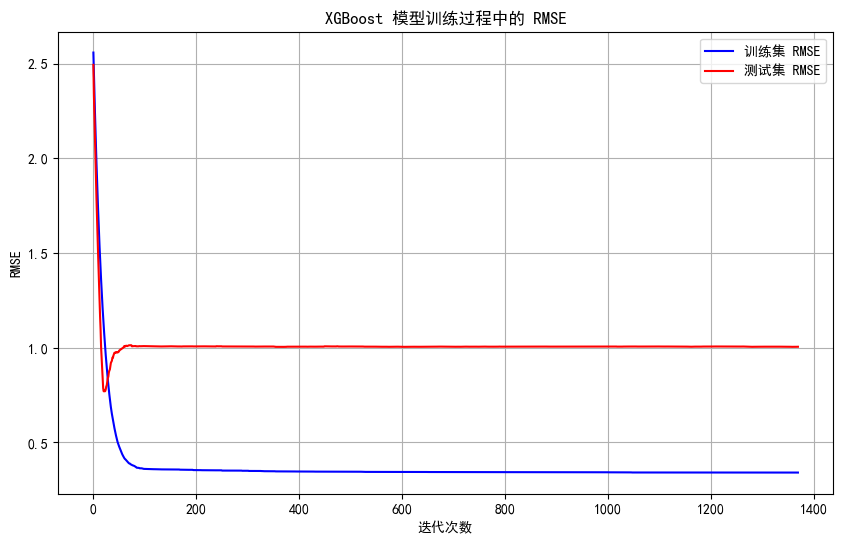

In [7]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重


# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:6.53025


[500]	train-rmse:0.12170


[1000]	train-rmse:0.11866


[1500]	train-rmse:0.11792


[2000]	train-rmse:0.11645


[2500]	train-rmse:0.11529


[3000]	train-rmse:0.11448


[3042]	train-rmse:0.11448


全部数据 MSE: 0.0131, 全部数据 R²: 0.9997


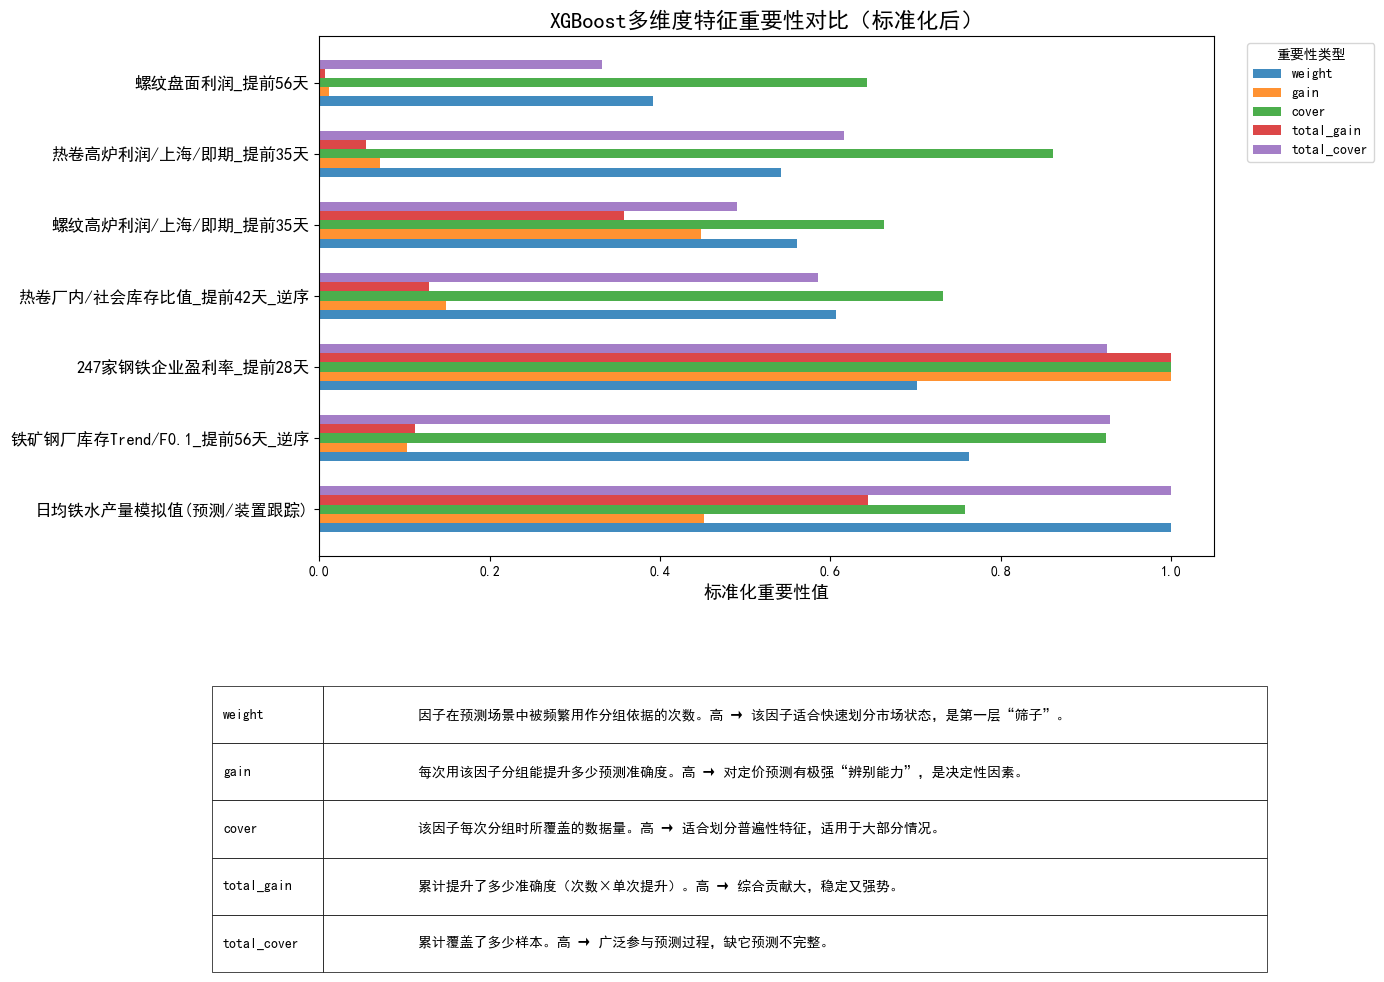

,weight,gain,cover,total_gain,total_cover
日均铁水产量模拟值(预测/装置跟踪),1.000000,0.451789,0.758462,0.644013,1.000000
铁矿钢厂库存Trend/F0.1_提前56天_逆序,0.762357,0.103213,0.923110,0.112164,0.927851
247家钢铁企业盈利率_提前28天,0.701521,1.000000,1.000000,1.000000,0.924926
热卷厂内/社会库存比值_提前42天_逆序,0.606464,0.148603,0.732103,0.128467,0.585387
螺纹高炉利润/上海/即期_提前35天,0.560837,0.447611,0.662559,0.357846,0.489922
热卷高炉利润/上海/即期_提前35天,0.541825,0.071820,0.861640,0.055471,0.615533
螺纹盘面利润_提前56天,0.391635,0.012041,0.643168,0.006722,0.332103


In [9]:
plot_xgb_feature_importance(model_all, X_train)

Gap between last actual value and first prediction: -0.6269775390624943


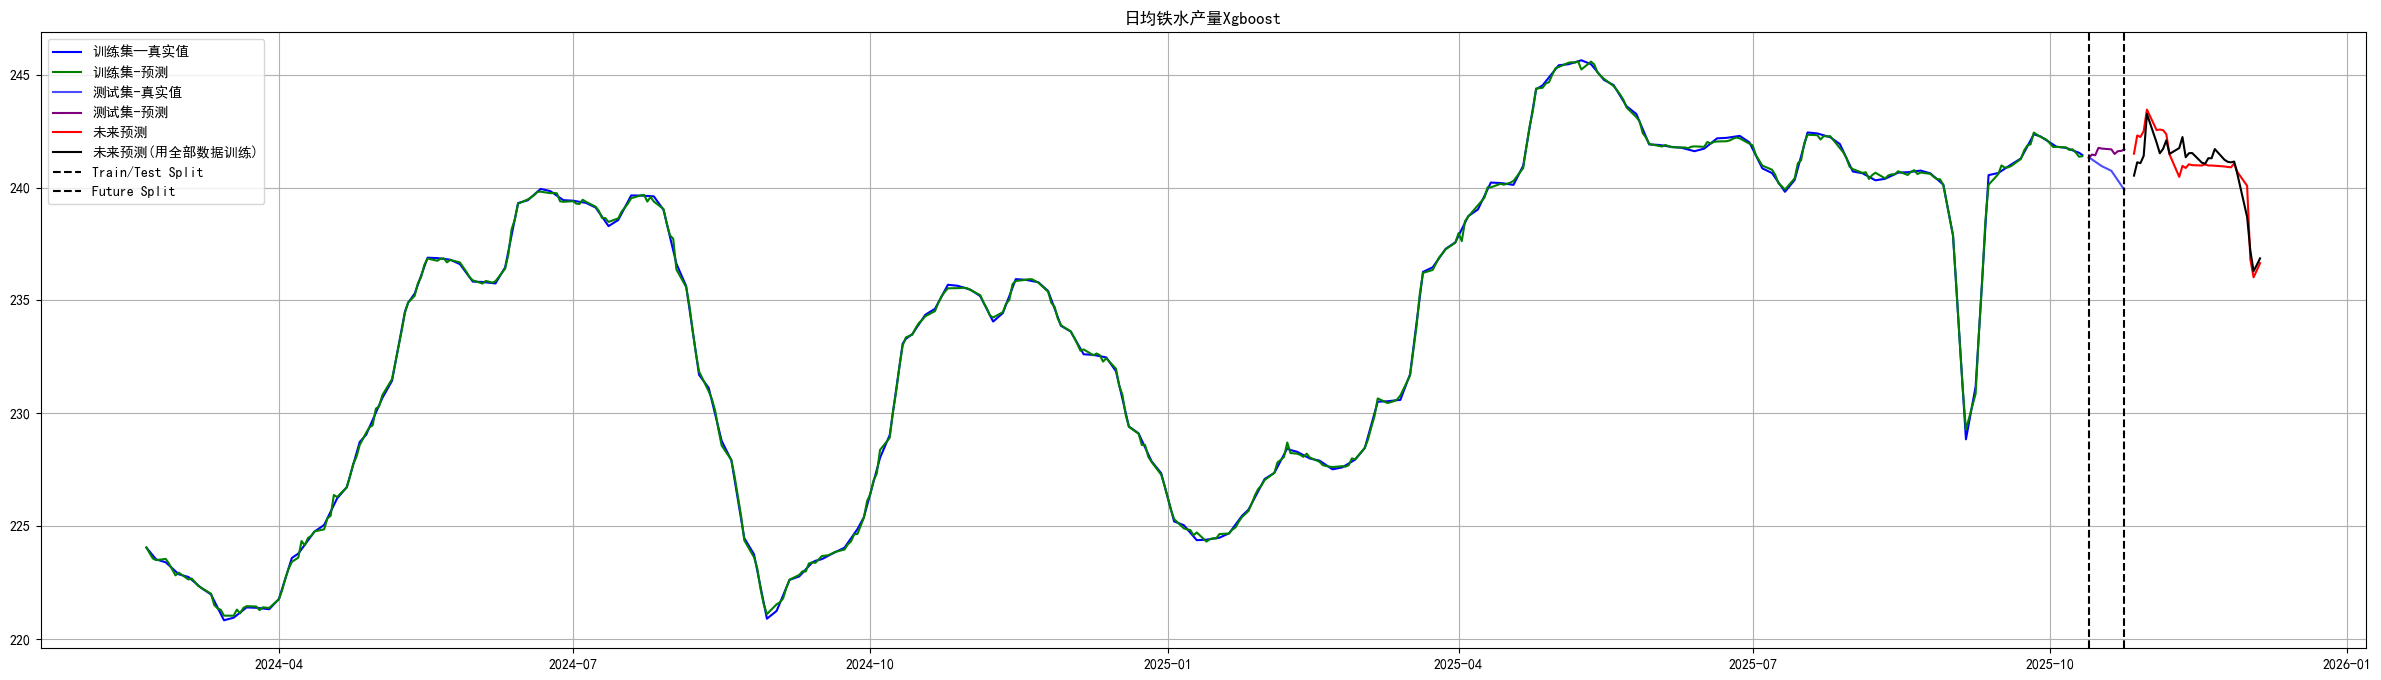

In [10]:
# 对future_data['预测值_全量']进行平滑处理
# 使用移动平均进行平滑,窗口大小为3,center=True确保平滑后数据对齐
'''
future_data['预测值_全量_平滑'] = future_data['预测值_全量'].rolling(window=10, center=True).mean()
future_data['预测值_全量_平滑'] = future_data['预测值_全量_平滑'].fillna(future_data['预测值_全量'])
future_data['预测值_全量'] = future_data['预测值_全量_平滑']
future_data = future_data.drop('预测值_全量_平滑', axis=1)
future_data = plot_predictions(y_test, future_data, col=True, label=True)
'''
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('日均铁水产量Xgboost')
plt.legend()
plt.grid(True)
plt.show()


---

In [11]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')

merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/日均铁水产量_合并数据.xlsx', index=False,float_format='%.4f')
merged_df_daily

,Date,真实值,预测值
479,2025/12/05,NaN,236.859680
478,2025/12/04,NaN,236.567078
477,2025/12/03,NaN,236.293655
476,2025/12/02,NaN,237.201416
475,2025/12/01,NaN,238.697632
...,...,...,...
4,2024/02/26,223.388000,NaN
3,2024/02/23,223.520000,NaN
2,2024/02/22,223.693333,NaN
1,2024/02/21,223.866667,NaN


In [12]:

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/日均铁水产量_月度数据.xlsx', index=False,float_format= '%.4f')

In [13]:
merged_df_monthly

,Date,真实值,预测值
22,2025/12/31,NaN,237.123901
21,2025/11/30,NaN,241.443207
20,2025/10/31,241.195789,241.590500
19,2025/09/30,238.518261,238.524246
18,2025/08/31,240.531905,240.560684
17,2025/07/31,241.332522,241.339737
16,2025/06/30,241.935333,241.932312
15,2025/05/31,244.421894,244.406754
14,2025/04/30,241.068406,241.036621
13,2025/03/31,232.956667,232.933456


In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.铁矿_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "日均铁水产量"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.铁矿_数据上传.xlsx"
sheet_name = "详情页"
identifier = "日均铁水产量"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
